In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import RandomSampler
from warmup_scheduler import GradualWarmupScheduler
import albumentations
from work.utils.dataset import RGB2Fusion, PandasDataset
from work.utils.models import EfficientNet
from work.utils.train import train_model
from work.utils.metrics import model_checkpoint
import random
import matplotlib.pyplot as plt

In [2]:
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../efficientnet-b0-08094119.pth'
}
data_dir = '../../dataset'
images_dir = os.path.join(data_dir, 'tiles')

df_train = pd.read_csv(f"../data/train_5fold.csv")

In [3]:
seed = 42
shuffle = True
batch_size = 2

num_workers = 4
output_classes = 5
init_lr = 3e-4
warmup_factor = 10
warmup_epochs = 1
n_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
loss_function = nn.BCEWithLogitsLoss()

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


Using device: cuda


In [4]:
transforms = albumentations.Compose([
    RGB2Fusion(mode="sum", space_colors=["rgb", "xyz", "lab"]),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])

valid_transforms =albumentations.Compose([
    RGB2Fusion(mode="sum", space_colors=["rgb", "xyz", "lab"]),
])

In [5]:
df_train.columns = df_train.columns.str.strip()

train_indexes = np.where((df_train['fold'] != 3))[0]
valid_indexes = np.where((df_train['fold'] == 3))[0]

train = df_train.loc[train_indexes]
valid = df_train.loc[valid_indexes]

train_dataset = PandasDataset(images_dir, train, transforms=transforms)
valid_dataset = PandasDataset(images_dir, valid, transforms=valid_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, num_workers=num_workers, sampler = RandomSampler(train_dataset)
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=2, num_workers=num_workers, sampler = RandomSampler(valid_dataset)
)

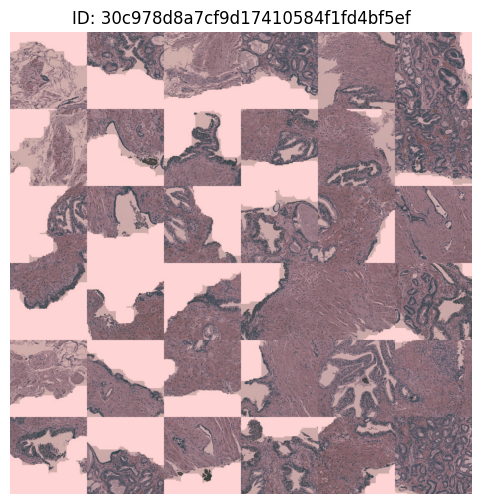

In [7]:
data_iter = iter(train_loader)
images, labels, ids = next(data_iter)

img = images[0]

plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis('off')
plt.title(f'ID: {ids[0]}')
plt.savefig("sum.png", dpi=300)
plt.show()

In [8]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_classes,
    pre_trained_model=pretrained_model
)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [9]:
optimizer = optim.Adam(model.parameters(), lr = init_lr / warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs - warmup_epochs)
scheduler = GradualWarmupScheduler(optimizer, multiplier = warmup_factor, total_epoch = warmup_epochs, after_scheduler=scheduler_cosine)
save_path = f'models/with-noise-fusion-sum-3-images.pth'

In [10]:
train_model(
    model=model,
    epochs=n_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    checkpoint=model_checkpoint,
    device=device,
    loss_function=loss_function,
    path_to_save_metrics="logs/with-noise-fusion-sum-3-images.txt",
    path_to_save_model=save_path
)

Epoch 1/15



100%|██████████| 903/903 [14:22<00:00,  1.05it/s]


metrics {'val_loss': 0.34566057, 'val_acc': {'mean': 41.318504092097285, 'std': 1.18692885465863, 'ci_5': 39.49861392378807, 'ci_95': 43.271468579769135}, 'val_kappa': {'mean': 0.7446213869522482, 'std': 0.011132813717848711, 'ci_5': 0.726148375039094, 'ci_95': 0.7625870299550125}, 'val_f1': {'mean': 0.3909444074332714, 'std': 0.011847791432980476, 'ci_5': 0.37142096608877184, 'ci_95': 0.40993762016296387}, 'val_recall': {'mean': 0.38986421754956246, 'std': 0.012228060934391266, 'ci_5': 0.37015400528907777, 'ci_95': 0.4099824160337448}, 'val_precision': {'mean': 0.41411321359872816, 'std': 0.011638095322156872, 'ci_5': 0.39510504305362704, 'ci_95': 0.43276347815990446}}
Salvando o melhor modelo... 0.0 -> 0.7446213869522482
Epoch 2/15



100%|██████████| 903/903 [14:34<00:00,  1.03it/s]


metrics {'val_loss': 0.33548766, 'val_acc': {'mean': 47.05085873305798, 'std': 1.163825435835236, 'ci_5': 45.207756757736206, 'ci_95': 49.030470848083496}, 'val_kappa': {'mean': 0.7611851161852837, 'std': 0.011975715566299451, 'ci_5': 0.7410513926573751, 'ci_95': 0.7800941220459706}, 'val_f1': {'mean': 0.397231524169445, 'std': 0.011516383742351437, 'ci_5': 0.3782063782215118, 'ci_95': 0.41631586849689484}, 'val_recall': {'mean': 0.4074555568099022, 'std': 0.010582641276129722, 'ci_5': 0.3902468726038933, 'ci_95': 0.42476408928632736}, 'val_precision': {'mean': 0.46126438161730765, 'std': 0.01601301466390917, 'ci_5': 0.43592036664485934, 'ci_95': 0.4881362795829773}}
Salvando o melhor modelo... 0.7446213869522482 -> 0.7611851161852837
Epoch 3/15



100%|██████████| 903/903 [14:24<00:00,  1.04it/s]


metrics {'val_loss': 0.30576235, 'val_acc': {'mean': 56.97933512330055, 'std': 1.1866323037311455, 'ci_5': 55.06648004055023, 'ci_95': 59.002768993377686}, 'val_kappa': {'mean': 0.7995147995203773, 'std': 0.011676501453340184, 'ci_5': 0.7800151625982653, 'ci_95': 0.8185008675977545}, 'val_f1': {'mean': 0.48745873764157294, 'std': 0.012390730625906893, 'ci_5': 0.4667301535606384, 'ci_95': 0.5080445975065231}, 'val_recall': {'mean': 0.48158928158879283, 'std': 0.011482688738693606, 'ci_5': 0.4631592661142349, 'ci_95': 0.5004771322011947}, 'val_precision': {'mean': 0.5212733136415482, 'std': 0.013813745939115373, 'ci_5': 0.49859162271022794, 'ci_95': 0.544031423330307}}
Salvando o melhor modelo... 0.7611851161852837 -> 0.7995147995203773
Epoch 4/15



100%|██████████| 903/903 [14:24<00:00,  1.04it/s]


metrics {'val_loss': 0.3182411, 'val_acc': {'mean': 58.81889181137085, 'std': 1.2189666065263598, 'ci_5': 56.84210658073425, 'ci_95': 60.83379238843918}, 'val_kappa': {'mean': 0.8025321770022906, 'std': 0.011991236928213831, 'ci_5': 0.7816417854423138, 'ci_95': 0.8221371570736332}, 'val_f1': {'mean': 0.49851263454556466, 'std': 0.01248744001521372, 'ci_5': 0.47765099704265596, 'ci_95': 0.5197100430727005}, 'val_recall': {'mean': 0.4934858876466751, 'std': 0.01154742245606022, 'ci_5': 0.47420857548713685, 'ci_95': 0.5133215874433518}, 'val_precision': {'mean': 0.5298025441169739, 'std': 0.01366754511786104, 'ci_5': 0.5057720184326172, 'ci_95': 0.5523994237184524}}
Salvando o melhor modelo... 0.7995147995203773 -> 0.8025321770022906
Epoch 5/15



100%|██████████| 903/903 [14:22<00:00,  1.05it/s]


metrics {'val_loss': 0.33613122, 'val_acc': {'mean': 59.09977819919586, 'std': 1.2149105907711277, 'ci_5': 57.17451572418213, 'ci_95': 61.10803484916687}, 'val_kappa': {'mean': 0.8075096421357303, 'std': 0.012028995282142333, 'ci_5': 0.7862347657529435, 'ci_95': 0.8268872674297414}, 'val_f1': {'mean': 0.5037192325294018, 'std': 0.012518088835522186, 'ci_5': 0.4831134960055351, 'ci_95': 0.5247967898845672}, 'val_recall': {'mean': 0.4983212542831898, 'std': 0.011642762634441632, 'ci_5': 0.4789119139313698, 'ci_95': 0.5177834868431092}, 'val_precision': {'mean': 0.5336267229914665, 'std': 0.01352421198622789, 'ci_5': 0.5104544073343277, 'ci_95': 0.5567766278982162}}
Salvando o melhor modelo... 0.8025321770022906 -> 0.8075096421357303
Epoch 6/15



100%|██████████| 903/903 [14:23<00:00,  1.05it/s]


metrics {'val_loss': 0.35101953, 'val_acc': {'mean': 60.00360100865364, 'std': 1.2046477188377094, 'ci_5': 58.00554156303406, 'ci_95': 62.04985976219177}, 'val_kappa': {'mean': 0.8131535037761539, 'std': 0.0117994928467787, 'ci_5': 0.793399939938574, 'ci_95': 0.8321401402771238}, 'val_f1': {'mean': 0.5205968886613845, 'std': 0.01250307800164813, 'ci_5': 0.5004214912652969, 'ci_95': 0.5415458112955094}, 'val_recall': {'mean': 0.5153144720494747, 'std': 0.011932312225668568, 'ci_5': 0.4958764210343361, 'ci_95': 0.5354236423969269}, 'val_precision': {'mean': 0.5440234436392785, 'std': 0.013261463653868483, 'ci_5': 0.522924742102623, 'ci_95': 0.5653774201869964}}
Salvando o melhor modelo... 0.8075096421357303 -> 0.8131535037761539
Epoch 7/15



100%|██████████| 903/903 [14:17<00:00,  1.05it/s]


metrics {'val_loss': 0.38874656, 'val_acc': {'mean': 60.21911340355873, 'std': 1.2141524220000732, 'ci_5': 58.28254818916321, 'ci_95': 62.271469831466675}, 'val_kappa': {'mean': 0.8136303053676212, 'std': 0.011906115105798452, 'ci_5': 0.79358508982734, 'ci_95': 0.8333359875543622}, 'val_f1': {'mean': 0.5282933912873268, 'std': 0.012630514581703391, 'ci_5': 0.5080875247716904, 'ci_95': 0.5495060741901397}, 'val_recall': {'mean': 0.5229035035073757, 'std': 0.012254833558366873, 'ci_5': 0.5028924643993378, 'ci_95': 0.5433579504489898}, 'val_precision': {'mean': 0.5483996806740761, 'std': 0.013172149160398171, 'ci_5': 0.5277143836021423, 'ci_95': 0.570564129948616}}
Salvando o melhor modelo... 0.8131535037761539 -> 0.8136303053676212
Epoch 8/15



100%|██████████| 903/903 [14:19<00:00,  1.05it/s]


metrics {'val_loss': 0.4321817, 'val_acc': {'mean': 60.71351797580719, 'std': 1.166336475409583, 'ci_5': 58.836567401885986, 'ci_95': 62.66205161809921}, 'val_kappa': {'mean': 0.8110435087093856, 'std': 0.012128482258718456, 'ci_5': 0.7907929460050745, 'ci_95': 0.8310941996069805}, 'val_f1': {'mean': 0.5385479549765587, 'std': 0.012118516270437535, 'ci_5': 0.5186701208353043, 'ci_95': 0.559711930155754}, 'val_recall': {'mean': 0.5322859835326672, 'std': 0.011811173091230524, 'ci_5': 0.5132073879241943, 'ci_95': 0.5528292059898376}, 'val_precision': {'mean': 0.5575134082436561, 'std': 0.012528256306573627, 'ci_5': 0.5359712213277816, 'ci_95': 0.5799832046031952}}
Epoch 9/15



100%|██████████| 903/903 [14:14<00:00,  1.06it/s]


metrics {'val_loss': 0.4626047, 'val_acc': {'mean': 60.62470908761024, 'std': 1.1912411973991177, 'ci_5': 58.67035984992981, 'ci_95': 62.548476457595825}, 'val_kappa': {'mean': 0.8145328093316896, 'std': 0.011862728959962028, 'ci_5': 0.795288411069185, 'ci_95': 0.8349517436628776}, 'val_f1': {'mean': 0.5402855268120765, 'std': 0.012269699389278325, 'ci_5': 0.5194997608661651, 'ci_95': 0.56050965487957}, 'val_recall': {'mean': 0.5366091229319573, 'std': 0.012056825464184115, 'ci_5': 0.5165107250213623, 'ci_95': 0.5565682053565979}, 'val_precision': {'mean': 0.5529233239889145, 'std': 0.012561326210201078, 'ci_5': 0.5319709986448288, 'ci_95': 0.5737701714038849}}
Salvando o melhor modelo... 0.8136303053676212 -> 0.8145328093316896
Epoch 10/15



100%|██████████| 903/903 [14:13<00:00,  1.06it/s]


metrics {'val_loss': 0.4941954, 'val_acc': {'mean': 60.75556783676147, 'std': 1.2003547155062313, 'ci_5': 58.725762367248535, 'ci_95': 62.714684009552}, 'val_kappa': {'mean': 0.818578246859698, 'std': 0.011863441528087547, 'ci_5': 0.7990162230657059, 'ci_95': 0.8386653143130602}, 'val_f1': {'mean': 0.5473499135971069, 'std': 0.012297030321962072, 'ci_5': 0.5271803140640259, 'ci_95': 0.5672726809978486}, 'val_recall': {'mean': 0.5449663922190666, 'std': 0.012276299912162836, 'ci_5': 0.5246878921985626, 'ci_95': 0.565148088335991}, 'val_precision': {'mean': 0.555264830172062, 'std': 0.012397971956677224, 'ci_5': 0.534080958366394, 'ci_95': 0.5755145013332367}}
Salvando o melhor modelo... 0.8145328093316896 -> 0.818578246859698
Epoch 11/15



100%|██████████| 903/903 [14:16<00:00,  1.05it/s]


metrics {'val_loss': 0.54327255, 'val_acc': {'mean': 60.225263035297395, 'std': 1.1637220951738039, 'ci_5': 58.28254818916321, 'ci_95': 62.05262988805771}, 'val_kappa': {'mean': 0.8193665078448373, 'std': 0.011515810507839843, 'ci_5': 0.8003856134293383, 'ci_95': 0.8390511881635352}, 'val_f1': {'mean': 0.5412298130393028, 'std': 0.011966290249446721, 'ci_5': 0.5217638701200485, 'ci_95': 0.560643994808197}, 'val_recall': {'mean': 0.5401170870661736, 'std': 0.011986285034543355, 'ci_5': 0.520431461930275, 'ci_95': 0.559769481420517}, 'val_precision': {'mean': 0.5471188488602639, 'std': 0.012061600736117806, 'ci_5': 0.5275484591722488, 'ci_95': 0.5667141199111938}}
Salvando o melhor modelo... 0.818578246859698 -> 0.8193665078448373
Epoch 12/15



100%|██████████| 903/903 [14:13<00:00,  1.06it/s]


metrics {'val_loss': 0.5757902, 'val_acc': {'mean': 60.06166189908981, 'std': 1.1781424430500607, 'ci_5': 58.11357080936432, 'ci_95': 61.99445724487305}, 'val_kappa': {'mean': 0.81735450321131, 'std': 0.011726691033384399, 'ci_5': 0.7977477303183689, 'ci_95': 0.8373221525415677}, 'val_f1': {'mean': 0.5418525992035865, 'std': 0.01207932343650866, 'ci_5': 0.521715858578682, 'ci_95': 0.5620190322399139}, 'val_recall': {'mean': 0.541576100885868, 'std': 0.012176847054873121, 'ci_5': 0.5219219535589218, 'ci_95': 0.562099689245224}, 'val_precision': {'mean': 0.546600531756878, 'std': 0.012125961762057817, 'ci_5': 0.5265245646238327, 'ci_95': 0.5672425359487534}}
Epoch 13/15



100%|██████████| 903/903 [14:12<00:00,  1.06it/s]


metrics {'val_loss': 0.6141043, 'val_acc': {'mean': 60.237562137842176, 'std': 1.166718855675237, 'ci_5': 58.28254818916321, 'ci_95': 62.1052622795105}, 'val_kappa': {'mean': 0.8171423315124196, 'std': 0.01154409656803532, 'ci_5': 0.7978372773501725, 'ci_95': 0.836536203349978}, 'val_f1': {'mean': 0.544571834564209, 'std': 0.012124814447229687, 'ci_5': 0.5248930931091309, 'ci_95': 0.5652567952871322}, 'val_recall': {'mean': 0.5460375185608863, 'std': 0.012227238368725168, 'ci_5': 0.5261180341243744, 'ci_95': 0.5666902989149094}, 'val_precision': {'mean': 0.5480566464662552, 'std': 0.012157704713615127, 'ci_5': 0.5281780570745468, 'ci_95': 0.5689809948205948}}
Epoch 14/15



100%|██████████| 903/903 [14:11<00:00,  1.06it/s]


metrics {'val_loss': 0.62858653, 'val_acc': {'mean': 59.9045427441597, 'std': 1.1760095065404932, 'ci_5': 58.06094408035278, 'ci_95': 61.82825565338135}, 'val_kappa': {'mean': 0.8157489325616277, 'std': 0.011540120165274203, 'ci_5': 0.7966858098601282, 'ci_95': 0.8350050944785101}, 'val_f1': {'mean': 0.5391547551751137, 'std': 0.012207990057227093, 'ci_5': 0.5198503792285919, 'ci_95': 0.5598107606172562}, 'val_recall': {'mean': 0.5413104912638664, 'std': 0.012356005790924393, 'ci_5': 0.5220993548631668, 'ci_95': 0.5621786087751388}, 'val_precision': {'mean': 0.5416995776295662, 'std': 0.012184043056197393, 'ci_5': 0.5223284423351288, 'ci_95': 0.5625012457370758}}
Epoch 15/15



100%|██████████| 903/903 [14:21<00:00,  1.05it/s]


metrics {'val_loss': 0.64247686, 'val_acc': {'mean': 60.29196662902832, 'std': 1.1727200764366896, 'ci_5': 58.39335322380066, 'ci_95': 62.271469831466675}, 'val_kappa': {'mean': 0.8169359608132013, 'std': 0.011522279808301214, 'ci_5': 0.798355954157785, 'ci_95': 0.8363389600171757}, 'val_f1': {'mean': 0.5438838649988175, 'std': 0.012176612021696889, 'ci_5': 0.524701076745987, 'ci_95': 0.5647251456975937}, 'val_recall': {'mean': 0.5473560162782669, 'std': 0.012291687893919418, 'ci_5': 0.5280446201562882, 'ci_95': 0.5687006801366806}, 'val_precision': {'mean': 0.5452676113843918, 'std': 0.012192765135719829, 'ci_5': 0.5265589624643325, 'ci_95': 0.5658555448055267}}
